In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import numpy as np
import nltk
import re
import time
from statistics import mean

from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

In [4]:
data=pd.read_csv("spam.csv", encoding = "latin-1")

In [5]:
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [6]:
data = data.dropna(how = "any", axis = 1)


Filtered out empty values

In [7]:
data.columns = ['label', 'body_text']

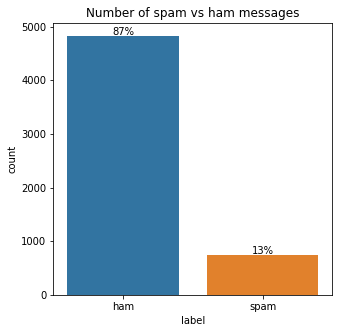

In [8]:
total = len(data)
plt.figure(figsize = (5, 5))
plt.title("Number of spam vs ham messages")
ax = sns.countplot(x = 'label', data = data)
for p in ax.patches:
    percentage = '{0:.0f}%'.format(p.get_height() / total * 100)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 20
    ax.annotate(percentage, (x, y), ha = 'center')
plt.show()

Number of spam and ham emails in dataset; inference : data imbalance

In [9]:
data['body_len'] = data.body_text.apply(lambda x: len(x) - x.count(" "))



/var/folders/fd/_vqm4qqj113dx_9dmjpjrhfw0000gn/T/ipykernel_721/2806681120.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['body_len'] = data.body_text.apply(lambda x: len(x) - x.count(" "))


In [10]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3) * 100 

In [11]:
data['punct%']=data.body_text.apply(lambda x: count_punct(x))

/var/folders/fd/_vqm4qqj113dx_9dmjpjrhfw0000gn/T/ipykernel_721/1740160740.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['punct%']=data.body_text.apply(lambda x: count_punct(x))


In [12]:
data

,label,body_text,body_len,punct%
0,ham,"Go until jurong point, crazy.. Available only ...",92,9.8
1,ham,Ok lar... Joking wif u oni...,24,25.0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,4.7
3,ham,U dun say so early hor... U c already then say...,39,15.4
4,ham,"Nah I don't think he goes to usf, he lives aro...",49,4.1
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,132,6.1
5568,ham,Will Ì_ b going to esplanade fr home?,30,6.7
5569,ham,"Pity, * was in mood for that. So...any other s...",48,14.6
5570,ham,The guy did some bitching but I acted like i'd...,100,1.0


Created new features for analyzing in both spam and ham texts.
bodylen-number of words
punct%-amount of punctuations in the text

Next step: Visualise with respect to the newly created feature :bodylen

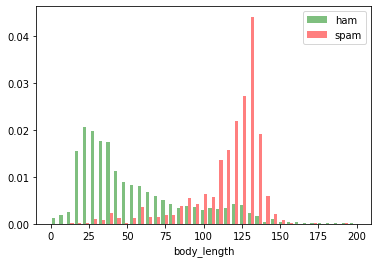

In [13]:
ham_count= data[data.label=='ham'].body_len
spam_count=data[data.label=='spam'].body_len
plt.style.use('seaborn-deep')
bins = np.linspace(0, 200, 40)
plt.hist([ham_count, spam_count], bins,alpha = 0.5,density = True ,label=['ham', 'spam'],color=['green','red'])
plt.xlabel('body_length')
plt.legend(loc='upper right')
plt.show()

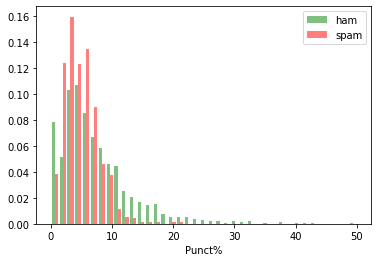

In [14]:
#Next step: Visualise with respect to the newly created feature : punct%

ham_count= data[data.label=='ham']['punct%']
spam_count=data[data.label=='spam']['punct%']
plt.style.use('seaborn-deep')
bins = np.linspace(0, 50, 40)
plt.hist([ham_count, spam_count], bins,alpha = 0.5,density = True ,label=['ham', 'spam'],color=['green','red'])
plt.xlabel('Punct%')


plt.legend(loc='upper right')
plt.show()

In [15]:
###DATA CLEANING###
#Initialising stemmers and stopowrds
#Lowercase and tokeniying followed by stopword elimination

In [16]:
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')

In [17]:
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.findall('\S+', text)
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    return text
# Apply function to body_text 
data['cleaned_text'] = data['body_text'].apply(lambda x: clean_text(x))
data[['body_text', 'cleaned_text']].head(10)

,body_text,cleaned_text
0,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n..."
1,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]"
2,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]"
4,"Nah I don't think he goes to usf, he lives aro...","[nah, dont, think, go, usf, life, around, though]"
5,FreeMsg Hey there darling it's been 3 week's n...,"[freemsg, hey, darling, 3, week, word, back, i..."
6,Even my brother is not like to speak with me. ...,"[even, brother, like, speak, treat, like, aid,..."
7,As per your request 'Melle Melle (Oru Minnamin...,"[per, request, melle, melle, oru, minnaminungi..."
8,WINNER!! As a valued network customer you have...,"[winner, valued, network, customer, selected, ..."
9,Had your mobile 11 months or more? U R entitle...,"[mobile, 11, month, u, r, entitled, update, la..."


In [18]:
#Find occurences of words in both spam and non spam and visualize

In [19]:
cleaned_ham = list(data.loc[data.label == 'ham', 'cleaned_text'])
cleaned_ham = list(np.concatenate(cleaned_ham).flat)

ham_words = Counter(cleaned_ham)
ham_words=pd.DataFrame(ham_words.most_common(50), columns = ['word', 'frequency'])

In [20]:
cleaned_spam = list(data.loc[data.label == 'spam', 'cleaned_text'])
cleaned_spam = list(np.concatenate(cleaned_spam).flat)
spam_words = Counter(cleaned_spam)
spam_words=pd.DataFrame(spam_words.most_common(50), columns = ['word', 'frequency'])

In [21]:
#Define extra stopwords
extra_stopwords = ['u', 'im', '2', 'ur', 'ill', '4', 'lor', 'r', 'n', 'da', 'oh']

# Remove extra stopwords  
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: [word for word in x if word not in extra_stopwords])

Text(0.5, 1.0, '30 most common ham words')

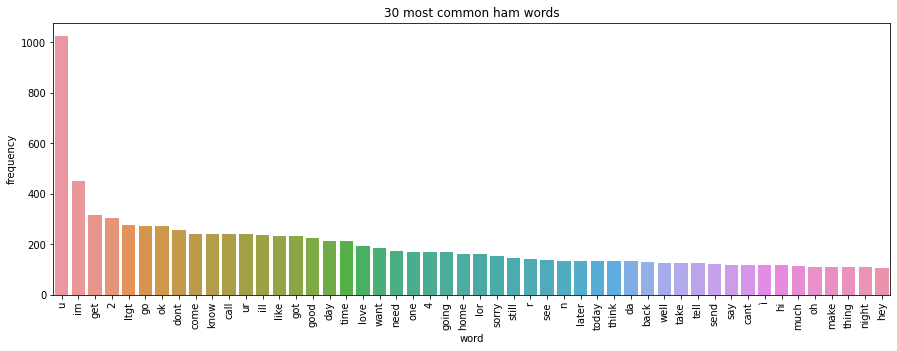

In [22]:
fig = plt.subplots(figsize = (15, 5))
sns.barplot(x = 'word', y = 'frequency', data = ham_words)
plt.xticks(rotation = '90')
plt.title("30 most common ham words")

Text(0.5, 1.0, '30 most common spam words')

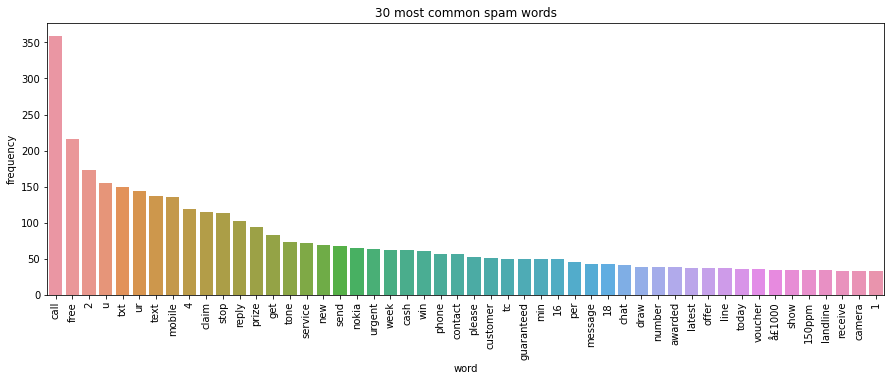

In [23]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x = 'word', y = 'frequency', data = spam_words, ax = ax)
plt.xticks(rotation = '90')
plt.title("30 most common spam words")

In [24]:
data

,label,body_text,body_len,punct%,cleaned_text
0,ham,"Go until jurong point, crazy.. Available only ...",92,9.8,"[go, jurong, point, crazy, available, bugis, g..."
1,ham,Ok lar... Joking wif u oni...,24,25.0,"[ok, lar, joking, wif, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,4.7,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,39,15.4,"[dun, say, early, hor, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",49,4.1,"[nah, dont, think, go, usf, life, around, though]"
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,132,6.1,"[2nd, time, tried, contact, å£750, pound, priz..."
5568,ham,Will Ì_ b going to esplanade fr home?,30,6.7,"[ì, b, going, esplanade, fr, home]"
5569,ham,"Pity, * was in mood for that. So...any other s...",48,14.6,"[pity, mood, soany, suggestion]"
5570,ham,The guy did some bitching but I acted like i'd...,100,1.0,"[guy, bitching, acted, like, id, interested, b..."


In [74]:
#Modelling
X_train, X_test, Y_train, Y_test = train_test_split(data[['body_text', 'body_len', 'punct%']], data.label, random_state = 42, test_size = 0.2)

In [75]:
tfidf_vect = TfidfVectorizer(analyzer = clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['body_text'])

tfidf_train = tfidf_vect.transform(X_train['body_text'])
tfidf_test = tfidf_vect.transform(X_test['body_text'])

#Identified parameters from fit() and applying it on both train and test data for scaling

In [77]:
X_train = pd.concat([X_train[['body_len', 'punct%']].reset_index(drop = True), pd.DataFrame(tfidf_train.toarray())], axis = 1)
X_test = pd.concat([X_test[['body_len', 'punct%']].reset_index(drop = True), pd.DataFrame(tfidf_test.toarray())], axis = 1)

In [78]:
#Data split into train and test test, Proceeding to classification using random forest

In [83]:
def explore_rf_params(n, depth):

    rf=RandomForestClassifier(n_estimators=n,max_depth=depth,random_state=42,n_jobs=-1)
    rf_model=rf.fit(X_train,Y_train)
    y_predict=rf_model.predict(X_test)
    precision, recall, fscore, support = score(Y_test, y_predict, pos_label = 'spam', average = 'binary')
    print(f"Est: {n_est} / Depth: {depth} ---- Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / Accuracy: {round((y_predict==Y_test).sum() / len(y_predict), 3)} /Fscore: {fscore}")

for n_est in [50, 100, 150]:
    for depth in [10, 20, 30, None]:
        explore_rf_params(n_est, depth)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Est: 50 / Depth: 10 ---- Precision: 1.0 / Recall: 0.253 / Accuracy: 0.9 /Fscore: 0.4042553191489362


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Est: 50 / Depth: 20 ---- Precision: 1.0 / Recall: 0.547 / Accuracy: 0.939 /Fscore: 0.7068965517241379


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Est: 50 / Depth: 30 ---- Precision: 1.0 / Recall: 0.687 / Accuracy: 0.958 /Fscore: 0.8142292490118578


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Est: 50 / Depth: None ---- Precision: 1.0 / Recall: 0.847 / Accuracy: 0.979 /Fscore: 0.9169675090252708


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Est: 100 / Depth: 10 ---- Precision: 1.0 / Recall: 0.28 / Accuracy: 0.903 /Fscore: 0.43750000000000006


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Est: 100 / Depth: 20 ---- Precision: 1.0 / Recall: 0.553 / Accuracy: 0.94 /Fscore: 0.7124463519313305


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Est: 100 / Depth: 30 ---- Precision: 1.0 / Recall: 0.693 / Accuracy: 0.959 /Fscore: 0.8188976377952756


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Est: 100 / Depth: None ---- Precision: 1.0 / Recall: 0.833 / Accuracy: 0.978 /Fscore: 0.9090909090909091


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Est: 150 / Depth: 10 ---- Precision: 1.0 / Recall: 0.253 / Accuracy: 0.9 /Fscore: 0.4042553191489362


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Est: 150 / Depth: 20 ---- Precision: 1.0 / Recall: 0.527 / Accuracy: 0.936 /Fscore: 0.6899563318777292


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Est: 150 / Depth: 30 ---- Precision: 1.0 / Recall: 0.693 / Accuracy: 0.959 /Fscore: 0.8188976377952756
Est: 150 / Depth: None ---- Precision: 1.0 / Recall: 0.827 / Accuracy: 0.977 /Fscore: 0.9051094890510949


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [87]:
#Due to class imbalance, F1 score is also required to be considered, fitting the model with 50 estimators
rf = RandomForestClassifier(n_estimators = 50, max_depth = None, random_state = 42, n_jobs = -1)
start=time.time()
model=rf.fit(X_train,Y_train)
end=time.time()
fit_time=start-end

start = time.time()
Y_pred = model.predict(X_test)
end = time.time()
pred_time = end - start

precision, recall, fscore, support = score(Y_test, Y_pred, pos_label = 'spam', average = 'binary')
print(f"Fit time: {round(fit_time, 3)} / Predict time: {round(pred_time, 3)}")
print(f"Precision: {round(precision, 3)} / Recall: {round(recall, 3)} / Accuracy: {round((Y_pred==Y_test).sum() / len(Y_pred), 3)} //Fscore: {fscore}")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Fit time: -0.533 / Predict time: 0.037
Precision: 1.0 / Recall: 0.847 / Accuracy: 0.979 //Fscore: 0.9169675090252708


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


<AxesSubplot:>

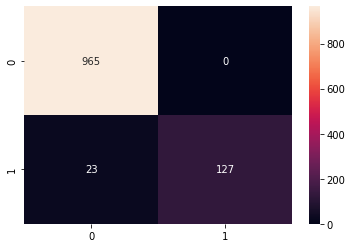

In [90]:
c_matrix=confusion_matrix(Y_test,Y_pred)
sns.heatmap(c_matrix, annot=True,fmt='d')


In [98]:
transformer = make_column_transformer((tfidf_vect, 'body_text'), remainder = 'passthrough')

rf_pipeline = make_pipeline(transformer, rf)

rf_score = cross_val_score(rf_pipeline, data[['body_text', 'body_len', 'punct%']], data.label, cv = 5, scoring = 'accuracy', n_jobs = -1)
mean(rf_score)

0.97200151355355

In [ ]:
#Cost of wrongly classifying a ham message as spam is very high. Hence this model is chosen compared to others.